In [1]:
import logging

def configure_logging(debug=False):
    if debug:
        logging.basicConfig(level=logging.DEBUG)
    else:
        logging.basicConfig(level=logging.INFO)
        
# Turn on debugging
configure_logging(debug=False)


# !pip install logging
# from dotenv import load_dotenv
# _ = load_dotenv()
#llama3-groq-70b-8192-tool-use-preview

import os
from langchain_groq import ChatGroq
import getpass
# KnowledgeGraphTool
import requests
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
from langchain_core.tools import tool


from langchain_core.prompts import PromptTemplate


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph IoT Engine"
# Load a specific environment variable
GKGraph_API_KEY = os.environ.get('GKGraph_API_KEY')
TAVILY_API_KEY=os.environ.get('TAVILY_API_KEY')
# model = ChatGroq(model="llama3-8b-8192")
llm = ChatGroq(model="llama3-8b-8192" , temperature =0)

from tavily import TavilyClient
# Step 1. Instantiating your TavilyClient
tavily_client = TavilyClient(api_key=TAVILY_API_KEY)



# !pip install langgraph-checkpoint-sqlite
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3
import re
import json

db = sqlite3.connect(":memory:", check_same_thread=False)
memory = SqliteSaver(db)


from langchain_core.output_parsers import JsonOutputParser

parser = JsonOutputParser()


def prepaer_states(json_obj):
    """
    Ensure all keys are present in the JSON object. 
    If a key is missing, set its value to None.

    Args:
        json_obj (dict): The JSON object to check.
        keys (list): List of keys to ensure in the JSON object.

    Returns:
        dict: The updated JSON object with all specified keys.
    """
    keys = [ "handled", "make_sense", "node"]
    for key in keys:
        if key not in json_obj:
            json_obj[key] = [None]
    return json_obj

In [2]:
from langchain_core.output_parsers import JsonOutputParser
assistant_prompt= """
Act as an assistant  and answer user queries ONLY if you can 
User queries may fall into one of the following categories:
1- Greeting/General: Greeting you or answering a general question that you can ONLY answer.
2- Service Recommendation: Asking for a recommendation for a service or a place to visit, such as I want to drink coffee, I am looking for a Middle Eastern restaurant, or Do you know any close hospital?
3- Hard Question: General questions you can't answer, such as: who is the current president of the United States of America? Or any question related to current events happening as you don't have access to the current event happening right now. the user may ask you to look for it
Your response must follow the following JSON  objects based on each category:
 1- Greeting/General: you need to provide your response ONLY in a JSON object as shown:
 {
 "query-type": "greeting-general",
 "response": write your response here
}
2-Service Recommendation: try to extract the service type and the city, country, Address, or Coordinates if mentioned. Your response is ONLY a JSON object. This JSON object must follow the following structure and set false in bool format for the value of the keys that you can't extract.
 { 
    "query-type": "serivce-recommendation",
    "service": extracted service type, 
    "city": extracted city,
    "city": extracted country"
    "address": extracted address,
    "coordinates":[extracted  latitude, extracted longitude]
}
3- Hard Question/current events: extract the question from the user context and provide your response ONLY JSON object as shown:
{
 "query-type": "hard-question",
 "question": eactracted question based on the context of the user conversation
}

"""

generator_prompt="""
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
If you don't know the answer, just say that you don't know. Use three sentences maximum.

Question: {question} 

Context: {context} 
"""






# prompt_template = PromptTemplate.from_template(
#     """
#     Act as an assistant, generate a like-human response and recommend a service, giving the recommended service details in this JSON object.
# {JsonObject}
# Do not include any explanations.
# Provide a JSON response following this format without deviation.
# {answer}
# """
# )
# answer=json.dumps({"answer": "your response"})
# promptTemplate=prompt_template.format(JsonObject=JsonObject, answer=answer)
# return promptTemplate


In [8]:
from typing import TypedDict, Annotated, Sequence,List
import operator
from langchain_core.messages import BaseMessage,AnyMessage,filter_messages,ToolMessage,FunctionMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    handled: Annotated[List[bool], operator.add]
    make_sense: Annotated[List[bool], operator.add]
    node: Annotated[List[str], operator.add]
    query:str = ""
    response:str = ""
    context:str = ""  
    call:str=""


In [13]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph,StateGraph
from langchain_community.tools.tavily_search import TavilySearchResults
TavilySearch = TavilySearchResults(max_results=2) #increased number of results
from langchain_core.messages import SystemMessage


def assistant_agent(state: AgentState):
    print("assistent node")
    agent_state={}
    agent_state["node"]=["assistant_agent"]
    logging.info("entering asstiant node")
    messages = state["messages"]
    human_messages= filter_messages(messages, include_types="human")
    print(f"messages: \n {messages}")
    prompt=[SystemMessage(content=assistant_prompt)]+list(human_messages)
    print(prompt)
    response = llm.invoke(prompt)
    print(response)
    response_json=parser.parse(response.content)
    logging.info(f"response_json: {response_json}")
    if response_json["query-type"] == "greeting-general":
        logging.info("@assitant_router catch greeting-general")
        agent_state["call"]="reviewer_agent"
        agent_state["response"]=response_json["response"]
    elif response_json["query-type"] == "service-recommendation": 
        logging.info("@assitant_router catch serivce-recommendation")
        agent_state["call"]= "IoT-engine"
    else:
        logging.info(response_json)
        agent_state["query"]=response_json["question"]
        logging.info("@assitant_router no catch serivce-recommendation")
        agent_state["call"]= "scrapper"
    agent_state["messages"]=[response]    
    print("agent_state")
    return prepaer_states(agent_state)
    
def generator_agent(state: AgentState):
    question=state["query"]
    context=state["context"]
    messages = [
        SystemMessage(
            content=generator_prompt.format(question=question, context=context)
        )
        ]
    response = llm.invoke(messages)
    return prepaer_states({"messages":[response],"node":["generator_agent"], "response": response.content})

def reviewer_agent(state: AgentState):
    logging.info("entering reviewer node")
    dictionary= {"handled":[True], "make_sense":[True]}
    return prepaer_states(dictionary)

def IoT_engine(state: AgentState):
    logging.info("Using branch B")
    return input


def GoogleMaps(state: AgentState):
    logging.info("Using branch C")
    return input

def GoogleKnowledgeGraph(state: AgentState):
    logging.info("Using branch C")
    return input


def scrapper(state: AgentState):
    print(state)
        # Step 2. Executing a simple search query
#     messages=state["messages"]
#     human_messages=""
#     for  message in messages:
#         if message.type =='human':
#             human_messages+= " \n"+ message.content
#     logging.info(human_messages)
    humman_message=state["query"]
    print(f"humman_message {humman_message}")
    response = tavily_client.search(humman_message)
    len(response["results"])
    if(response["results"][0]):
        search_result=response["results"]
        logging.info(search_result)
        return prepaer_states({"messages":[ToolMessage(content= str(response["results"][0]), 
                                                       name="scrapper", 
                                                       tool_call_id ="call_scrapper")],
                               "handled":[True],
                               "node":["scrapper"],
                               "context": str(response["results"][0])
                              })
    else:
        return prepaer_states({"handled":[False]})


def assitant_router(state: AgentState):
#     logging.info("STATE at assitant_router:", state)
        return state["call"]

        

def scrapper_router(state: AgentState):
    logging.info("STATE at assitant_router:", state)
    messages = state["messages"]
    last_message = messages[-1]
    logging.info(last_message)
    last_handled= state["handled"]
    logging.info(state["handled"])
    if  state["handled"]:
        logging.info("@scrapper_router and handled true")
        return "generator_agent"
    else:
        return "generator_agent"

def reviewer_router(state: AgentState):
    logging.info("I'm in reviewer router")
    if  state["make_sense"]:
        logging.info("Make sense True at reviewer writer")
        return "END"
    else:
        return "IoT_engine"


def router(state: AgentState):
    if  state["make_sense"]:
        return "END"
    else:
        return "IoT_engine"
# graph = MessageGraph()
graph=StateGraph(AgentState)
graph.add_node("assistant_agent", assistant_agent)
graph.add_node("generator_agent", generator_agent)
graph.add_node("IoT_engine", IoT_engine)
graph.add_node("GoogleMaps", GoogleMaps)
graph.add_node("GoogleKnowledgeGraph", GoogleKnowledgeGraph)
graph.add_node("scrapper", scrapper)
graph.add_node("reviewer_agent", reviewer_agent)


# graph.add_edge("assistant_agent", "reviewer_agent")
# graph.add_edge("assistant_agent", "IoT_engine")

graph.add_conditional_edges(
    "assistant_agent", assitant_router, {"reviewer_agent": "reviewer_agent", "IoT_engine": "IoT_engine", "scrapper":"scrapper"}
)


graph.add_conditional_edges(
    "scrapper", scrapper_router, {"generator_agent": "generator_agent", "GoogleMaps": "GoogleMaps"}
)

# graph.add_edge("IoT_engine", "generator_agent")
# graph.add_edge("IoT_engine", "GoogleMaps")

graph.add_conditional_edges(
    "IoT_engine", router, {"generator_agent": "generator_agent", "GoogleMaps": "GoogleMaps"}
)

# graph.add_edge("GoogleMaps", "generator_agent")
# graph.add_edge("GoogleMaps", "GoogleKnowledgeGraph")
graph.add_conditional_edges(
    "GoogleMaps", router, {"generator_agent": "generator_agent", "GoogleKnowledgeGraph": "GoogleKnowledgeGraph"}
)


# graph.add_edge("GoogleKnowledgeGraph", "generator_agent")
# graph.add_edge("GoogleKnowledgeGraph", "scrapper")
graph.add_conditional_edges(
    "GoogleKnowledgeGraph", router, {"generator_agent": "generator_agent","GoogleMaps":"GoogleMaps" , "scrapper": "scrapper"}
)

# graph.add_edge("scrapper", "generator_agent")

graph.add_edge("generator_agent","reviewer_agent")

graph.add_conditional_edges(
    "reviewer_agent", reviewer_router, { "scrapper": "scrapper", "GoogleMaps":"GoogleMaps" ,"END":END}
)


graph.set_entry_point("assistant_agent")

# runnable = graph.compile(checkpointer=memory,  interrupt_before=["scrapper", "generator_agent"])

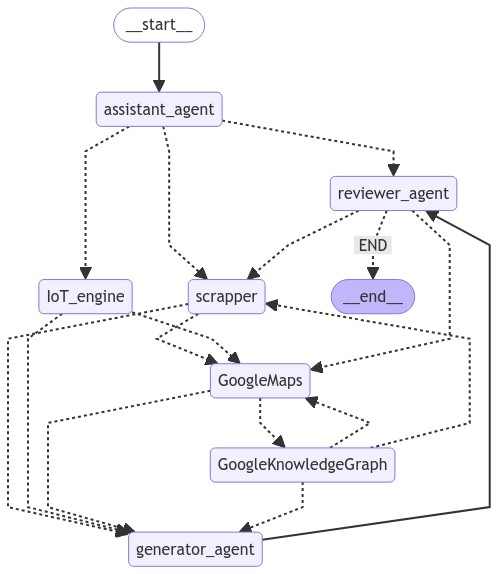

In [10]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [14]:
runnable = graph.compile(checkpointer=memory)

In [15]:

thread = {"configurable": {"thread_id": "aaa"}}


human_message = HumanMessage(content="what the current weather in Oshawa?")
messages = [human_message]

result = runnable.invoke(prepaer_states({"messages":messages}), thread)

INFO:root:entering asstiant node


assistent node
messages: 
 [HumanMessage(content='what the current weather in Oshawa?'), AIMessage(content='{\n  "query-type": "hard-question",\n  "question": "what the current weather in Oshawa?"\n}', response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 394, 'total_tokens': 420, 'completion_time': 0.020088275, 'prompt_time': 0.060638723, 'queue_time': None, 'total_time': 0.080726998}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_873a560973', 'finish_reason': 'stop', 'logprobs': None}, id='run-1085f0e0-38dc-4a2a-ad69-0168c728bc60-0', usage_metadata={'input_tokens': 394, 'output_tokens': 26, 'total_tokens': 420}), FunctionMessage(content='{\'title\': \'Weather in Oshawa\', \'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'Oshawa\', \'region\': \'Ontario\', \'country\': \'Canada\', \'lat\': 43.9, \'lon\': -78.87, \'tz_id\': \'America/Toronto\', \'localtime_epoch\': 1723670040, \'localtime\': \'2024-08-14 17:14\'}, \'c

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:response_json: {'query-type': 'hard-question', 'question': 'what the current weather in Oshawa?'}
INFO:root:{'query-type': 'hard-question', 'question': 'what the current weather in Oshawa?'}
INFO:root:@assitant_router no catch serivce-recommendation


content='{\n  "query-type": "hard-question",\n  "question": "what the current weather in Oshawa?"\n}' response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 413, 'total_tokens': 439, 'completion_time': 0.019999997, 'prompt_time': 0.062299285, 'queue_time': None, 'total_time': 0.082299282}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_af05557ca2', 'finish_reason': 'stop', 'logprobs': None} id='run-c6676b17-d3af-4868-9728-6a12599992ec-0' usage_metadata={'input_tokens': 413, 'output_tokens': 26, 'total_tokens': 439}
agent_state
{'messages': [HumanMessage(content='what the current weather in Oshawa?'), AIMessage(content='{\n  "query-type": "hard-question",\n  "question": "what the current weather in Oshawa?"\n}', response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 394, 'total_tokens': 420, 'completion_time': 0.020088275, 'prompt_time': 0.060638723, 'queue_time': None, 'total_time': 0.080726998}, 'model_name': 'llama3-8b-8192', 'sy

INFO:root:[{'title': 'Weather in Oshawa', 'url': 'https://www.weatherapi.com/', 'content': "{'location': {'name': 'Oshawa', 'region': 'Ontario', 'country': 'Canada', 'lat': 43.9, 'lon': -78.87, 'tz_id': 'America/Toronto', 'localtime_epoch': 1723670335, 'localtime': '2024-08-14 17:18'}, 'current': {'last_updated_epoch': 1723670100, 'last_updated': '2024-08-14 17:15', 'temp_c': 27.0, 'temp_f': 80.6, 'is_day': 1, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 8.1, 'wind_kph': 13.0, 'wind_degree': 200, 'wind_dir': 'SSW', 'pressure_mb': 1020.0, 'pressure_in': 30.11, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 45, 'cloud': 0, 'feelslike_c': 27.6, 'feelslike_f': 81.6, 'windchill_c': 25.4, 'windchill_f': 77.7, 'heatindex_c': 26.2, 'heatindex_f': 79.1, 'dewpoint_c': 14.2, 'dewpoint_f': 57.6, 'vis_km': 11.0, 'vis_miles': 6.0, 'uv': 7.0, 'gust_mph': 9.2, 'gust_kph': 14.9}}", 'score': 0.9992078, 'raw_content': None}, {'title'

In [37]:
runnable.get_state(thread).next

('scrapper',)

In [13]:
[print(i) for i in runnable.get_state(thread)]

{'messages': [HumanMessage(content='Hi'), AIMessage(content='{\n  "query-type": "greeting-general",\n  "response": "Hello! How can I assist you today?"\n}', response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 375, 'total_tokens': 402, 'completion_time': 0.020814249, 'prompt_time': 0.057099822, 'queue_time': None, 'total_time': 0.077914071}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_873a560973', 'finish_reason': 'stop', 'logprobs': None}, id='run-821e67dc-40b8-4c38-a1fb-ceaab6989385-0', usage_metadata={'input_tokens': 375, 'output_tokens': 27, 'total_tokens': 402}), HumanMessage(content='Hi how are You? How I can help you')], 'handled': [None, None, True], 'make_sense': [None, None, True], 'node': [None, 'assistant_agent', None], 'response': 'Hello! How can I assist you today?', 'call': 'reviewer_agent'}
()
{'configurable': {'thread_id': '12', 'checkpoint_ns': '', 'checkpoint_id': '1ef5a722-eac6-6da9-8002-31bd11448166'}}
{'source': 'loop', 'write

[None, None, None, None, None, None]

In [22]:

runnable = graph.compile(checkpointer=memory,  interrupt_before=["scrapper", "generator_agent"])

thread = {"configurable": {"thread_id": "25f"}}


human_message = HumanMessage(content="do you know anything about langgraph?")
messages = [human_message]

# for event in runnable.stream(prepaer_states({"messages":messages}), thread):
#     for v in event.values():
#         print(v['messages'])
        
for event in runnable.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)
while runnable.get_state(thread).next:
    print("\n", runnable.get_state(thread),"\n")
    _input = input("proceed?")
    if _input != "y":
        print("aborting")
        break
    for event in runnable.stream(None, thread):
        for v in event.values():
            print(v)

INFO:root:entering asstiant node


assistent node
messages: 
 [HumanMessage(content='do you know who invented the car'), AIMessage(content='{\n  "query-type": "hard-question",\n  "question": "who invented the car"\n}', response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 381, 'total_tokens': 403, 'completion_time': 0.017200214, 'prompt_time': 0.112276011, 'queue_time': None, 'total_time': 0.129476225}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6a6771ae9c', 'finish_reason': 'stop', 'logprobs': None}, id='run-670f5153-942a-482d-9493-5ef84600619d-0', usage_metadata={'input_tokens': 381, 'output_tokens': 22, 'total_tokens': 403}), SystemMessage(content='[{\'title\': \'A History of Cars: The Invention of the Automobile - ThoughtCo\', \'url\': \'https://www.thoughtco.com/who-invented-the-car-4059932\', \'content\': "A History of the Automobile\\nThe Evolution of the Car Dates All the Way Back to the 1600s\\nThe very first self-powered road vehicles were powered by steam engines, and by 

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:response_json: {'query-type': 'hard-question', 'question': 'who invented the car'}
INFO:root:{'query-type': 'hard-question', 'question': 'who invented the car'}
INFO:root:@assitant_router no catch serivce-recommendation


content='{\n  "query-type": "hard-question",\n  "question": "who invented the car"\n}' response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 2083, 'total_tokens': 2105, 'completion_time': 0.017051383, 'prompt_time': 0.374599651, 'queue_time': None, 'total_time': 0.39165103399999995}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6a6771ae9c', 'finish_reason': 'stop', 'logprobs': None} id='run-7e261dc9-764d-499b-a9c2-597aae009788-0' usage_metadata={'input_tokens': 2083, 'output_tokens': 22, 'total_tokens': 2105}
agent_state
{'messages': [AIMessage(content='{\n  "query-type": "hard-question",\n  "question": "who invented the car"\n}', response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 2083, 'total_tokens': 2105, 'completion_time': 0.017051383, 'prompt_time': 0.374599651, 'queue_time': None, 'total_time': 0.39165103399999995}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6a6771ae9c', 'finish_reason': 'stop', 'logprob

proceed?y
{'messages': [HumanMessage(content='do you know who invented the car'), AIMessage(content='{\n  "query-type": "hard-question",\n  "question": "who invented the car"\n}', response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 381, 'total_tokens': 403, 'completion_time': 0.017200214, 'prompt_time': 0.112276011, 'queue_time': None, 'total_time': 0.129476225}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6a6771ae9c', 'finish_reason': 'stop', 'logprobs': None}, id='run-670f5153-942a-482d-9493-5ef84600619d-0', usage_metadata={'input_tokens': 381, 'output_tokens': 22, 'total_tokens': 403}), SystemMessage(content='[{\'title\': \'A History of Cars: The Invention of the Automobile - ThoughtCo\', \'url\': \'https://www.thoughtco.com/who-invented-the-car-4059932\', \'content\': "A History of the Automobile\\nThe Evolution of the Car Dates All the Way Back to the 1600s\\nThe very first self-powered road vehicles were powered by steam engines, and by that

INFO:root:[{'title': 'A History of Cars: The Invention of the Automobile - ThoughtCo', 'url': 'https://www.thoughtco.com/who-invented-the-car-4059932', 'content': "A History of the Automobile\nThe Evolution of the Car Dates All the Way Back to the 1600s\nThe very first self-powered road vehicles were powered by steam engines, and by that definition, Nicolas Joseph Cugnot of France built the\xa0first automobile\xa0in 1769 — recognized by the British Royal Automobile Club and the Automobile Club de France as being the first. If Siegfried Marcus built his second car in 1875 and it was as claimed, it would have been the first vehicle powered by a four-cycle engine and the first to use gasoline as a fuel, the first having a carburetor for a gasoline engine and the first having a magneto ignition. The Heart of the Automobile\nAn internal combustion engine is an engine that uses the explosive combustion of fuel to push a piston within a cylinder —\xa0the piston's movement turns a crankshaft t

INFO:root:[None, True, None, True]
INFO:root:@scrapper_router and handled true


{'messages': [SystemMessage(content='[{\'title\': \'A History of Cars: The Invention of the Automobile - ThoughtCo\', \'url\': \'https://www.thoughtco.com/who-invented-the-car-4059932\', \'content\': "A History of the Automobile\\nThe Evolution of the Car Dates All the Way Back to the 1600s\\nThe very first self-powered road vehicles were powered by steam engines, and by that definition, Nicolas Joseph Cugnot of France built the\\xa0first automobile\\xa0in 1769 — recognized by the British Royal Automobile Club and the Automobile Club de France as being the first. If Siegfried Marcus built his second car in 1875 and it was as claimed, it would have been the first vehicle powered by a four-cycle engine and the first to use gasoline as a fuel, the first having a carburetor for a gasoline engine and the first having a magneto ignition. The Heart of the Automobile\\nAn internal combustion engine is an engine that uses the explosive combustion of fuel to push a piston within a cylinder —\\xa

proceed?y


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:entering reviewer node
INFO:root:I'm in reviewer router
INFO:root:Make sense True at reviewer writer


{'messages': [AIMessage(content='Nicolas-Joseph Cugnot of France built the first automobile in 1769, recognized by the British Royal Automobile Club and the Automobile Club de France as being the first.', response_metadata={'token_usage': {'completion_tokens': 38, 'prompt_tokens': 1321, 'total_tokens': 1359, 'completion_time': 0.029748993, 'prompt_time': 0.20028355, 'queue_time': None, 'total_time': 0.230032543}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_873a560973', 'finish_reason': 'stop', 'logprobs': None}, id='run-70064390-6c8d-4f66-91ec-131da584645e-0', usage_metadata={'input_tokens': 1321, 'output_tokens': 38, 'total_tokens': 1359})], 'handled': [None], 'make_sense': [None], 'node': ['generator_agent'], 'response': AIMessage(content='Nicolas-Joseph Cugnot of France built the first automobile in 1769, recognized by the British Royal Automobile Club and the Automobile Club de France as being the first.', response_metadata={'token_usage': {'completion_tokens': 38, 'p

In [41]:
# runnable.get_state(thread).next

for event in runnable.stream(None, thread):
    for v in event.values():
        print(v)

INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:entering reviewer node
INFO:root:I'm in reviewer router
INFO:root:Make sense True at reviewer writer


{'messages': [AIMessage(content='According to the context, the current weather in Egypt is clear with a temperature of 30.2°C (86.4°F) in Cairo.', response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 929, 'total_tokens': 960, 'completion_time': 0.024017832, 'prompt_time': 0.142518341, 'queue_time': None, 'total_time': 0.16653617299999998}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'finish_reason': 'stop', 'logprobs': None}, id='run-e7d2ee22-2798-4cd7-b395-a4fc29156552-0', usage_metadata={'input_tokens': 929, 'output_tokens': 31, 'total_tokens': 960})], 'handled': [None], 'make_sense': [None], 'node': ['generator_agent'], 'response': AIMessage(content='According to the context, the current weather in Egypt is clear with a temperature of 30.2°C (86.4°F) in Cairo.', response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 929, 'total_tokens': 960, 'completion_time': 0.024017832, 'prompt_time': 0.142518341, 'queue_tim

In [39]:
import pandas as pd
df=pd.DataFrame(result)
df.head()

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,messages,handled,make_sense,node,query,call
0,content='what is weather now in Egypt',None,None,None,what is weather now in Egypt,scrapper
1,"content='{\n ""query-type"": ""hard-question"",\n...",None,None,assistant_agent,what is weather now in Egypt,scrapper


In [23]:
x="""
sddfsdfdsf \n\n {y}
"""

print(x.format(y="fdsfdf"))


sddfsdfdsf 

 fdsfdf



In [24]:
runnable.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='do you know who invented the car'), AIMessage(content='{\n  "query-type": "hard-question",\n  "question": "who invented the car"\n}', response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 381, 'total_tokens': 403, 'completion_time': 0.017200214, 'prompt_time': 0.112276011, 'queue_time': None, 'total_time': 0.129476225}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6a6771ae9c', 'finish_reason': 'stop', 'logprobs': None}, id='run-670f5153-942a-482d-9493-5ef84600619d-0', usage_metadata={'input_tokens': 381, 'output_tokens': 22, 'total_tokens': 403}), SystemMessage(content='[{\'title\': \'A History of Cars: The Invention of the Automobile - ThoughtCo\', \'url\': \'https://www.thoughtco.com/who-invented-the-car-4059932\', \'content\': "A History of the Automobile\\nThe Evolution of the Car Dates All the Way Back to the 1600s\\nThe very first self-powered road vehicles were powered by steam engines, 

In [25]:
for i in runnable.get_state(thread):
    print(i)

{'messages': [HumanMessage(content='do you know who invented the car'), AIMessage(content='{\n  "query-type": "hard-question",\n  "question": "who invented the car"\n}', response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 381, 'total_tokens': 403, 'completion_time': 0.017200214, 'prompt_time': 0.112276011, 'queue_time': None, 'total_time': 0.129476225}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6a6771ae9c', 'finish_reason': 'stop', 'logprobs': None}, id='run-670f5153-942a-482d-9493-5ef84600619d-0', usage_metadata={'input_tokens': 381, 'output_tokens': 22, 'total_tokens': 403}), SystemMessage(content='[{\'title\': \'A History of Cars: The Invention of the Automobile - ThoughtCo\', \'url\': \'https://www.thoughtco.com/who-invented-the-car-4059932\', \'content\': "A History of the Automobile\\nThe Evolution of the Car Dates All the Way Back to the 1600s\\nThe very first self-powered road vehicles were powered by steam engines, and by that definitio

In [27]:
x= runnable.get_state(thread)

In [28]:
for i in x:
    print(i)

{'messages': [HumanMessage(content='do you know who invented the car'), AIMessage(content='{\n  "query-type": "hard-question",\n  "question": "who invented the car"\n}', response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 381, 'total_tokens': 403, 'completion_time': 0.017200214, 'prompt_time': 0.112276011, 'queue_time': None, 'total_time': 0.129476225}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6a6771ae9c', 'finish_reason': 'stop', 'logprobs': None}, id='run-670f5153-942a-482d-9493-5ef84600619d-0', usage_metadata={'input_tokens': 381, 'output_tokens': 22, 'total_tokens': 403}), SystemMessage(content='[{\'title\': \'A History of Cars: The Invention of the Automobile - ThoughtCo\', \'url\': \'https://www.thoughtco.com/who-invented-the-car-4059932\', \'content\': "A History of the Automobile\\nThe Evolution of the Car Dates All the Way Back to the 1600s\\nThe very first self-powered road vehicles were powered by steam engines, and by that definitio

In [16]:
result["response"]

'According to the provided context, the current weather in Oshawa is sunny with a temperature of 27.0°C (80.6°F).'

In [15]:
for m in result["messages"]:
    print(m)
    print(type(m))

content='who invented the phone?'
<class 'langchain_core.messages.human.HumanMessage'>
content='{\n  "query-type": "hard-question",\n  "question": "who invented the phone?"\n}' response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 379, 'total_tokens': 401, 'completion_time': 0.016903638, 'prompt_time': 0.058031976, 'queue_time': None, 'total_time': 0.074935614}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_873a560973', 'finish_reason': 'stop', 'logprobs': None} id='run-f94595fe-d141-48f9-8464-c5ddcf14a18b-0' usage_metadata={'input_tokens': 379, 'output_tokens': 22, 'total_tokens': 401}
<class 'langchain_core.messages.ai.AIMessage'>
content="{'title': 'Alexander Graham Bell | Biography, Education, Telephone, Inventions ...', 'url': 'https://www.britannica.com/biography/Alexander-Graham-Bell', 'content': 'Alexander Graham Bell (born March 3, 1847, Edinburgh, Scotland—died August 2, 1922, Beinn Bhreagh, Cape Breton Island, Nova Scotia, Canada) Scottish-

In [21]:
result["messages"][-2]

HumanMessage(content='who invinted the car')

[HumanMessage(content='who invinted the car')]